## AI Travel Agent: Organising trips and finding best places to visit 🚀
This notebook is a Concierge multi-agent Agent AI assistant to suggest travel options for both leisure and business purposes using Google's ADK.

🎯 Objective: Ease the process and save time before finalising bookings.

Capstone Project is part of the 5-Day AI Agents Intensive Course with Google (Nov 10 - 14, 2025).

🌟 Key Features

- ✅ ***Multi-agent*** system architecture.

     * Search for flights based on destination
     * Searching for flight prices
     * Rank the top 3 cheapest flights
     * Parallel agent system framework to search for hotels annd prices - happens simultaneously with flight search.
     * Loop refinement agent to reinfe the output from the agent and not relyin on one-shot response: Flight Assistant, Price and hotel scouter → Orchestraror-LLM
     * Sequential Agent to manage and coordinate the agents workflow
     * Powered Coordinator: Root agent orchestrates the entire process → Final Suggestion
  
- ✅Custom-Function Tools
- ✅Save origin, destination, dates, hotel, flights
- Retrieve information
- ✅Check from the traveller his/her budget, pause based on the output and then finalises the suggestion.
- ✅Memory and Database storage for using session and states. Hold the memory of the proposed suggestion and trip of the user, needed if changing plans, add database using sqlite (long-term memory with databases).

***Workflow***:

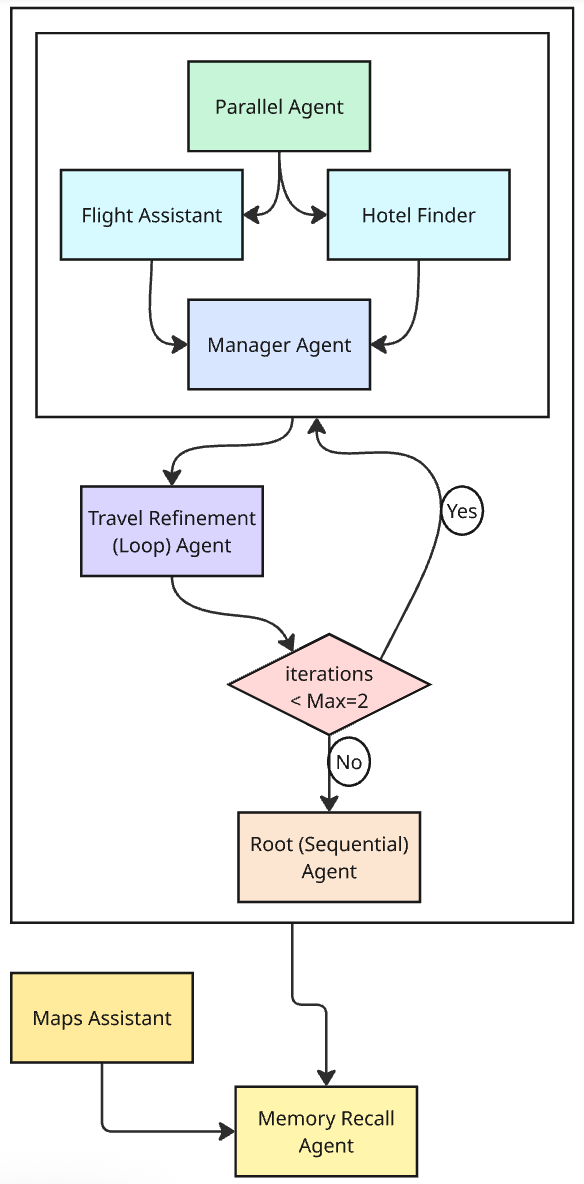

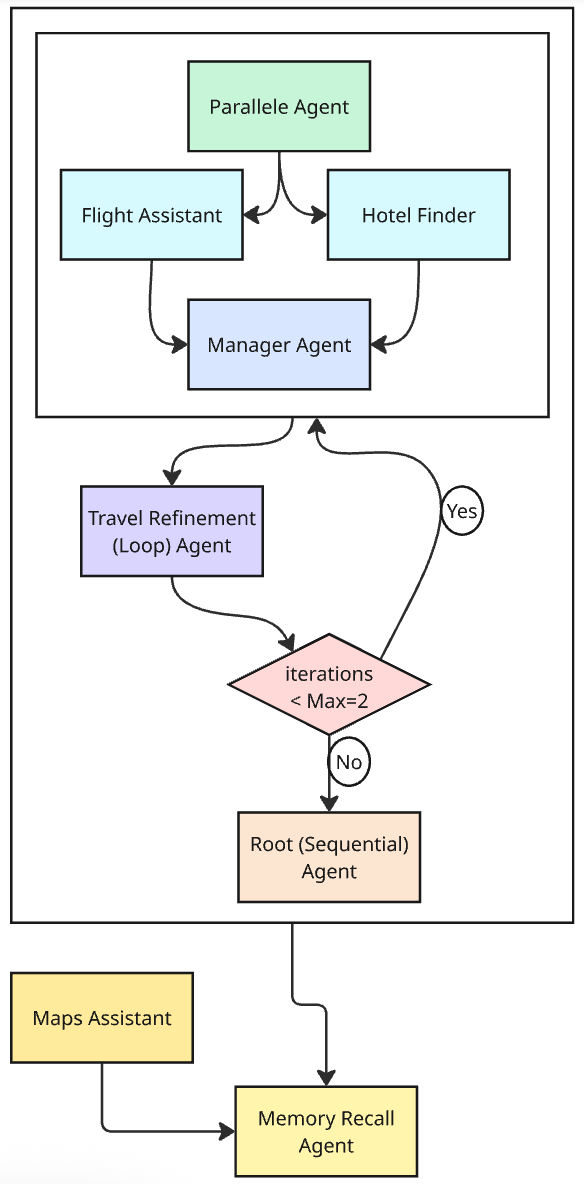

## Section 1: Setup ⚙️
Install any dependencies if not running within Kaggle Notebooks i.e. [google-adk](http://) library for Python, `!pip install google-adk`, configure Gemini API Key and performing authentication.

### 1.1 Gemini API Key configuration
* Gemini API key
* Google Map API key

In [ ]:
# Configure the Gemini API key
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: 'GOOGLE_API_KEY' failed to be added to the Kaggle secrets. Details: {e}")

***Google Map API key***:
Follow the documentation and generate an API key for [google maps](https://console.cloud.google.com/google/maps-apis/credentials?project=gen-ai-course-476317) to use Model Context Protocol [MCP-tools](https://google.github.io/adk-docs/tools-custom/mcp-tools/#step-2-implement-the-server-logic) calls to find restaraunts close to the hotel of the destination

* Generate a google cloud account
* Click on API & Services tab
* Follow the on - screen instructions 
* Continue on the free plan
* Add a card: you will NOT be charged
* Select Start Free
* Then go to : https://console.cloud.google.com/google/maps-apis/
* Select the Keys&Crederials
* Copy your key and add it as a separate key in the notebook using the 'Add-ons' tab.
* Add new secret. Make sure the label of the new secret matches 'GOOGLE_MAPS_API_KEY'. Paste you map-API key 

In [ ]:
# Configure GOOGLE_MAPS_API_KEY
try:
    GOOGLE_MAPS_API_KEY = UserSecretsClient().get_secret("GOOGLE_MAPS_API_KEY")
    os.environ["GOOGLE_MAPS_API_KEY"] = GOOGLE_MAPS_API_KEY
    print("✅ GOOGLE MAPS API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: 'GOOGLE_API_KEY' failed to be added to the Kaggle secrets. Details: {e}")

# Retrieve the API key from an environment variable or directly insert it.
# Using an environment variable is generally safer.
# Ensure this environment variable is set in the terminal where you run 'adk web'.
# Example: export GOOGLE_MAPS_API_KEY="YOUR_ACTUAL_KEY"
google_maps_api_key = os.environ.get("GOOGLE_MAPS_API_KEY")
if not google_maps_api_key:
    # Fallback or direct assignment for testing - NOT RECOMMENDED FOR PRODUCTION
    google_maps_api_key = "YOUR_GOOGLE_MAPS_API_KEY_HERE" # Replace if not using env var
    if google_maps_api_key == "YOUR_GOOGLE_MAPS_API_KEY_HERE":
        print("WARNING: GOOGLE_MAPS_API_KEY is not set. Please set it as an environment variable or in the script.")
        # You might want to raise an error or exit if the key is crucial and not found.

### 1.2 Import Agent Development Kit components and Generative AI libs.

In [ ]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LlmAgent, LoopAgent
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService, DatabaseSessionService
from google.adk.memory import InMemoryMemoryService

from google.adk.tools import load_memory
from google.adk.tools.tool_context import ToolContext
from google.genai.types import Content, Part


from google.genai import types
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.adk.models.google_llm import Gemini

from typing import Any, Dict
from google.adk.runners import Runner

# Configure the Gemini API key
from google.adk.tools.mcp_tool import McpToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters


print("✅ ADK components imported successfully.")

### 1.3 Configure Retry Options

In [ ]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

### 1.4 Define Helper Function

In [ ]:
async def run_session(
    runner_instance: Runner, 
    user_queries: list[str] | str, 
    session_id: str = "default"
):
    """Helper function to run queries in a session and display responses."""
    print(f"\n### Session: {session_id}")

    # Create or retrieve session
    try:
        session = await session_service.create_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )
    except:
        session = await session_service.get_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )

    # Convert single query to list
    if isinstance(user_queries, str):
        user_queries = [user_queries]

    # Process each query
    for query in user_queries:
        print(f"\nUser > {query}")
        query_content = types.Content(role="user", parts=[types.Part(text=query)])

        # Stream agent response
        async for event in runner_instance.run_async(
            user_id=USER_ID, session_id=session.id, new_message=query_content
        ):
            if event.is_final_response() and event.content and event.content.parts:
                text = event.content.parts[0].text
                if text and text != "None":
                    print(f"Model: > {text}")


print("✅ Helper functions defined.")

### 1.5 Define Tools

In [ ]:
# ---  Function Tools ---
# Create tool functions to the Agent for the database sql
def save_userinfo(
    tool_context: ToolContext, origin: str, destination: str,
    date_from:str, date_to: str, hotels:str
) -> Dict[str, Any]:
    """
    Tool to record and save user origin and destination city or country and the dates from and to in session state.

    """
    # Write to session state using the 'user:' prefix for user data
    tool_context.state["origin"] = origin
    tool_context.state["destination"] = destination
    tool_context.state["date_from"] = date_from
    tool_context.state["date_to"] = date_to
    tool_context.state["hotels"] = hotels

    return {"status": "success"}

def retrieve_flight_info(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Tool to retrieve user preferences for city origin, destination and dates from and to from session state.
    """
    # Read from session state
    origin = tool_context.state.get("origin", "Origin not found")
    destination = tool_context.state.get("destination", "Destination not found")
    date_from = tool_context.state.get("date_from", "Date from not found")
    date_to = tool_context.state.get("date_to", "Date to not found")
    hotels = tool_context.state.get("hotels", "Hotels not found")

    return {"status": "success", "origin": origin, "destination": destination,
            "date_from": date_from, "date_to": date_to, "hotels":hotels
           }

print("✅ Tools created.")

## Section 2: A multi-agent architechture for flight and hotel scanning 🤖 
- The AI agent architecture is:
  1. Function tools save and retrieve flights input needed from user
       * save_userinfo
       * retrieve_flight_info


  2. Multi-agent interaction
       * Flight Assistant agent finds the 3 cheapest flights based on users info
          * Uses a Google search tool
       * Hotel Finder agent finds the 3 hotels based on user info
          * Uses a Google search tool 
       * Manager Assistant calls the parallel agent (for flight assistant and hotel finder) and function tools orchestrating the conversation
         
       * Parallel agent:
          * Runs in parallel the flight assistant and hotel finder 

       * The Travel Refinement Agent (loop agent):
          * Refines the flight assistant and hotel assistant iterations
        
       * Sequential Agent: Orchestrates the workflow and determines in sequence of agents 

  3. MCP tool and Map agent:
       * Google maps and MAPs is used for finding restaurants and closeby places to visit
    
  4. Long term memory and Information Retrieval
       * Saves the found flights/hotels and user indput into a database
       * Uses a memory recall agent to load the info saved
 

#### 2.1 ARCHITECTURE OF AGENTS

In [ ]:
# --Constants--
USER_ID ="default"
#SESSION = "default"
APP_NAME = "MemoryDemoApp"
MODEL_NAME="gemini-2.5-flash-lite"
model_config = Gemini(model=MODEL_NAME, retry_options=retry_config)

# STEP 1: Initial flight_assistant, price_agent, hotel_scouter Agents (Runs ONCE)
#Agent Architecture:
# Flight Assistant
flight_assistant = Agent(
    model=MODEL_NAME,
    name="FlightAssistant",
    instruction="""
    You are a flight search specialist.
    1. Search google for flights matching the user's request.
    2. Return the top 3 cheapest options and include airline, airport of origin, airport of destination and indicative flight price.
    3. Restrict findings to 3 bullet points, one point per flight
    """,
    tools=[google_search],
    output_key="flight_search"
)

flight_assistant_tool = AgentTool(agent=flight_assistant)
print("✅ Flight Agent created!")

# Hotels Finder
hotel_finder = Agent(
    name="HotelFinder",
    model="gemini-2.5-flash-lite",
    instruction="""
    You are a hotel finder assistant.
    1. Search google for hotels matching the user's destination information.
    2. Return the highest reviewed but cheapest hotels where people stay in destination. Include price, hotel name and address. 
    3. Restrict findings to 3 bullet points, one point per hotel""",
    tools=[google_search],
    output_key="hotel_search"
)

hotel_finder_tool = AgentTool(agent=hotel_finder)
print("✅ Hotel finder Agent created!")

# Manager-Aggregator Agent:
manager_agent = LlmAgent(
    model=model_config,
    name="ManagerAgent",
    instruction="""
    You are a trip itinerary coordinator assistant.

    When users request a flight itinerary:
    1. Parse the user's request to extract origin, destination, date_from, and date_to, hotels and use save_userinfo tool to save the info, then use retrieve_flight_info tool to retrieve the info.
    2. USE the 'flight_assistant_tool' with these details to search the information about the flights and provide the 3 bulltet points given in {flight_search}
    3. USE the 'hotel_finder_tool' to search the information regarding the hotels and provide the 3 bulltet points given in {hotel_search}
    """,
    tools=[save_userinfo, retrieve_flight_info, flight_assistant_tool,
           hotel_finder_tool]
)

print("✅ Manager Agent created!")

# STEP 2: Refiner and Parallent Agent
# The ParallelAgent runs all its sub-agents simultaneously.
parallel_team = ParallelAgent(
    name="ParallelTeam",
    sub_agents=[flight_assistant, hotel_finder],
)

print("✅ Parallel Agent created!")

# Refiner Agent:
travel_refinement_loop = LoopAgent(
    name="TravelRefinementLoop",
    sub_agents=[parallel_team,manager_agent],
    max_iterations=2,  # 2 iteration, can increase if resources are available and prevents infinite loops
)

print("✅ Travel refinement Agent created!")

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
root_agent = SequentialAgent(
    name="SequentialAgent",
    sub_agents=[travel_refinement_loop],
)

print("✅ Sequential Agent created!")

#MAP agent using MCP tool and GOOGLE_MAPS_API_KEY
maps_assistant_agent = LlmAgent(
    model='gemini-2.0-flash',
    name='maps_assistant_agent',
    instruction='Help the user with mapping, directions, and finding places using Google Maps tools.',
    tools=[
        McpToolset(
            connection_params=StdioConnectionParams(
                server_params = StdioServerParameters(
                    command='npx',
                    args=[
                        "-y",
                        "@modelcontextprotocol/server-google-maps",
                    ],
                    # Pass the API key as an environment variable to the npx process
                    # This is how the MCP server for Google Maps expects the key.
                    env={
                        "GOOGLE_MAPS_API_KEY": google_maps_api_key
                    }
                ),
            ),
            # You can filter for specific Maps tools if needed:
            # tool_filter=['get_directions', 'find_place_by_id']
        )
    ],
)

print("✅ Maps Agent created!")


# Memory recall agent
memory_recall_agent = Agent(
    model=model_config,
    name="MemoryRecallAgent",
    instruction="Use the 'load_memory' tool "
                "the answer might be in past conversations.",
    tools=[load_memory],
    sub_agents= [maps_assistant_agent],
)
print("✅ Memory Recall Agent created!")

## Section 3: Set up Session Management, Add Memory and ask the Agent
Create a persistent memory service and back this with a vector DB.

1. Utilise the MCP tool (google maps)
2. Use a map agent to find restaurants and sights close to the hotel chosen

In [ ]:
# --- INITIALIZE MEMORY SERVICE ---
# Create a persistent memory service and back this with a vector DB
# Set up Session Management and Add Memory to the Agent
# InMemorySessionService stores conversations in RAM (temporary)
#session_service = InMemorySessionService()

memory_service= InMemoryMemoryService()
# Switch to DatabaseSessionService
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)
#runner = InMemoryRunner(agent=concierge_agent)

To proceed and call for agent response, instantiate two runners one for the `multi-agent` and one for the `memory recall agent` define:
1) sessionID = "multisession1"
2) sessionID = "sessionRetrieval" and redefine when re-running and testing.

This was used to check, before testing the helper function - also available to automated in future.

In [ ]:
async def run_scenario():
    runner1 = Runner(
        agent=root_agent,
        app_name=APP_NAME,
        session_service=session_service,
        memory_service=memory_service) # Memory service is now available!

    print("✅ Agent and Runner created with memory support!")
    print(f"   - Application: {APP_NAME}")
    print(f"   - Using: {session_service.__class__.__name__}")
    #print(f"   - Session: {SESSION}")

    sessionID = "mutlisession2"
    await runner1.session_service.create_session(app_name=APP_NAME, user_id=USER_ID, session_id=sessionID)
    user_input1 = Content(parts=[Part(text="Hi, my travel plans are: origin:Manchester,  destination:Rome, date_from: 1st of April 2026 date_to: 10th of April 2026")], role="user")

    # Run the agent
    final_response_text = "(no final response)"
    async for event in runner1.run_async(user_id=USER_ID, session_id=sessionID, new_message=user_input1):
            if event.is_final_response() and event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
    print(f"Agent 1 Response: {final_response_text}")

    # Get the completed session
    completed_session1 = await runner1.session_service.get_session(app_name=APP_NAME, user_id=USER_ID, session_id=sessionID)

    # Add this session's content to the Memory Service
    print("\n--- Adding Session 1 to Memory ---")
    await memory_service.add_session_to_memory(completed_session1)
    print("Session added to memory.")

    # Turn 2: Recall the information in a new session
    print("\n--- Turn 2: Recalling Information ---")
    runner2 = Runner(
            # Use the second agent, which has the memory tool
            agent=memory_recall_agent,
            app_name=APP_NAME,
            session_service=session_service, # Reuse the same service
            memory_service=memory_service   # Reuse the same service
        )
    sessionID = "sessionRetrieval2"
    await runner2.session_service.create_session(app_name=APP_NAME, user_id=USER_ID, session_id=sessionID)
    user_input2 = Content(parts=[Part(text="What is my destination I want to travel, what are my flight company and hotel options?"),
                                Part(text="Find me restaurant less than 0.5 mile close to the cheapest of the 3 hotels found.")], role="user")

    # Run the second agent
    final_response_text_2 = "(no final response)"
    async for event in runner2.run_async(user_id=USER_ID, session_id=sessionID, new_message=user_input2):
        if event.is_final_response() and event.content and event.content.parts:
            final_response_text_2 = event.content.parts[0].text
    print(f"Agent 2 Response: {final_response_text_2}")

import asyncio

# To run this example, you can use the following snippet:
run_scenario()

await run_scenario()

In [ ]:
runner1 = Runner(
        agent=root_agent,
        app_name=APP_NAME,
        session_service=session_service,
        memory_service=memory_service) # Memory service is now available!
session1 = await run_session(runner1,"Hi, my travel plans are: origin:Manchester,  destination:Paris, date_from:1st of April 2026 date_to: 10th of April 2026, min to 200 words",
                                 session_id="state_demo_session1") # Session ID

In [ ]:
runner2 = Runner(
        # Use the second agent, which has the memory tool
        agent=memory_recall_agent,
        app_name=APP_NAME,
        session_service=session_service, # Reuse the same service
        memory_service=memory_service   # Reuse the same service
    )
await run_session(runner2,"Where I want to travel?",
                                 "state_demo_session1") # Session ID

In [ ]:
await run_session(runner1,"Find 3 wine bars less than 1mile from the New Hotel Opéra",
                                 "state_demo_session")

In [ ]:
#session1 = await session_test.get_session(
#    app_name=APP_NAME, user_id=USER_ID, session_id="conversation-01"
#)
#print(session_test.events, session_test.state)
#
## Let's see what's in the session
#print("📝 Session contains:")
#for event in session_test.events:
#    text = (
#        event.content.parts[0].text[:60]
#        if event.content and event.content.parts
#        else "(empty)"
#    )
#    print(f"  {event.content.role}: {text}...")

In [ ]:
# Check of the database and the data stored
#import sqlite3

#def check_data_in_db():
#    with sqlite3.connect("my_agent_data.db") as connection:
#        cursor = connection.cursor()
#        result = cursor.execute(
#            "select app_name, session_id, author, content from events"
#        )
#        print([_[0] for _ in result.description])
#        for each in result.fetchall():
#            print(each)
#
#
#check_data_in_db()

In [ ]:
#Clean up any existing database to start fresh (if Notebook is restarted)
import os

if os.path.exists("my_agent_data.db"):
    os.remove("my_agent_data.db")
print("✅ Cleaned up old database files")

## Section 4. Summary 
* Built a multi-agent framework with long-term memory for travel  with ADK!
* Provides suggestions for flights and hotels
* Does not rely on one shot prompting

## Section5: Future Improvements
* Refactoring to automate the change of session ids that are saved in database
* Context compaction since the the session database will quickly add up.
* UI and interaction with the agents
* Evaluation

## ✈️ Enjoy your trip!  

#### Resources

1. Addison Howard, Brenda Flynn, Eric Schmidt, Kanchana Patlolla, Kinjal Parekh, María Cruz, Naz Bayrak, Polong Lin, and Ray Harvey. Agents Intensive - Capstone Project. https://kaggle.com/competitions/agents-intensive-capstone-project, 2025. Kaggle.
2. [ADK-Docs](https://google.github.io/adk-docs/)
3. [ADK-MCP tools](https://google.github.io/adk-docs/tools-custom/mcp-tools/#2-building-an-mcp-server-with-adk-tools-mcp-server-exposing-adk)
4. [ADK_Python](https://github.com/google/adk-python)
5. [ADK-setting-up-environments](https://google.github.io/adk-docs/grounding/google_search_grounding/#set-up-environment-install-adk)